# Simple implementation of Heikin-Ashi to get a flavour of algorithmic trading

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import functools as fn

from mpl_finance import candlestick_ohlc
from matplotlib.dates import date2num

## Load Apple data
The data comes from Yahoo Finance: https://finance.yahoo.com/quote/AAPL/history?period1=345423600&period2=1546642800&interval=1d&filter=history&frequency=1d

In [87]:
raw_apple = pd.read_csv('data/AAPL.csv')
apple = (
    raw_apple
    .rename(columns={col: col.lower().replace(' ', '_') 
        for col in raw_apple.columns})
    .assign(date=lambda df: pd.to_datetime(df['date']))
    .set_index('date')
    .dropna())

print(f'Shape: {apple.shape}')
apple.head()

Shape: (9597, 6)


,open,high,low,close,adj_close,volume
date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.023106,117258400.0
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.021900,43971200.0
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.020293,26432000.0
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.020795,21610400.0
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.021398,18362400.0


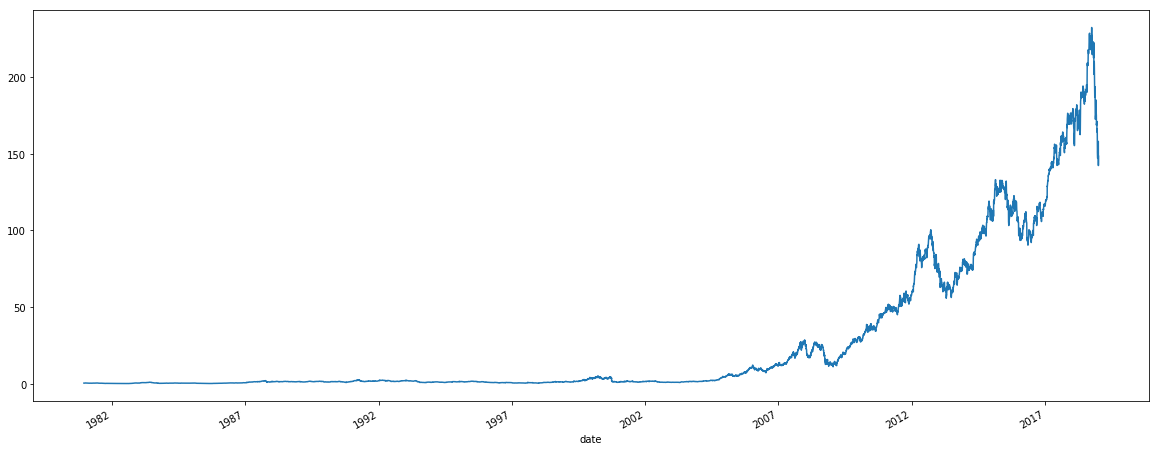

In [110]:
apple['close'].plot(figsize=(20, 8))
plt.show()

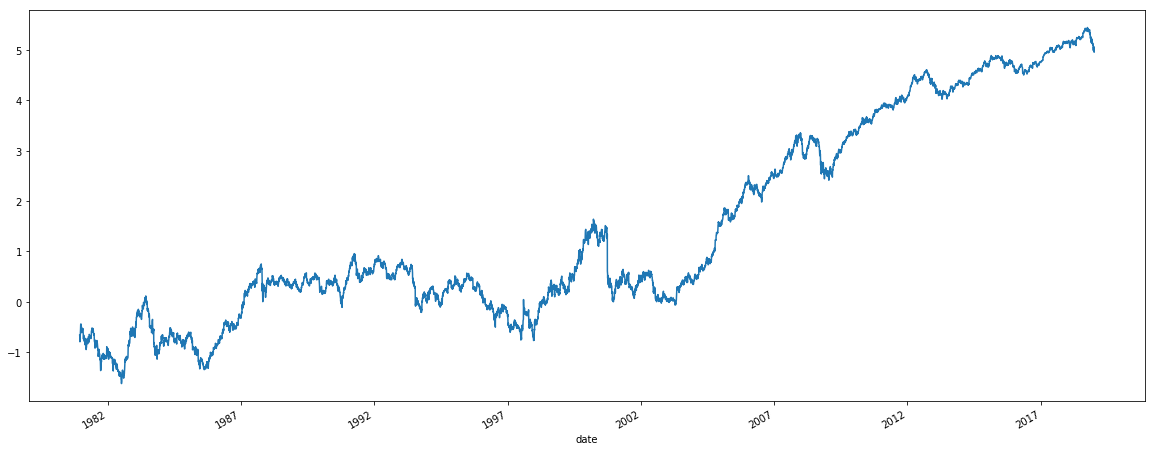

In [111]:
np.log(apple['close']).plot(figsize=(20, 8))
plt.show()

## Define the Heikin Ashi function

In [119]:
def heikin_ashi(df):    
    ha_close = (df['open'] + df['close'] + df['high'] + df['low']) / 4
    
    ha_open = [(df['open'].iloc[0] + df['close'].iloc[0]) / 2]
    for close in ha_close[:-1]:
        ha_open.append((ha_open[-1] + close) / 2)    
    ha_open = np.array(ha_open)

    elements = df['high'], df['low'], ha_open, ha_close
    ha_high, ha_low = np.vstack(elements).max(axis=0), np.vstack(elements).min(axis=0)
    
    return pd.DataFrame({
        'ha_open': ha_open,
        'ha_high': ha_high,    
        'ha_low': ha_low,
        'ha_close': ha_close
    }) 

In [144]:
# Simple test
test_df = apple[:5].drop(columns=['adj_close', 'volume'])

expected_heikin_ashi = pd.DataFrame(
    {'ha_open': [0.513393,0.513672,0.5006975,0.47635325,0.469482625],
     'ha_high': [0.515625,0.513672,0.5006975,0.47635325,0.477679],
     'ha_low': [0.513393,0.48660699999999996, 0.45089300000000004,0.462054,0.46948262],
     'ha_close': [0.513951,0.487723,0.452009,0.46261199999999997,0.47600425]},
    index=test_df.index)

actual_heikin_ashi = heikin_ashi(test_df)

pd.util.testing.assert_almost_equal(
    actual_heikin_ashi,
    expected_heikin_ashi)

## Candlestick plots

In [162]:
def plot_ha_candlestick(df, size=(20, 5)):
    fig, ax = plt.subplots()
    fig.set_size_inches(size)

    quotes = list(map(
        lambda x: x[1], 
        (df
         .reset_index()
         .rename(columns={'date': 'time'})
         .assign(time=lambda df: df['time'].map(date2num))
         .iterrows())))

    candlestick_ohlc(ax, quotes)

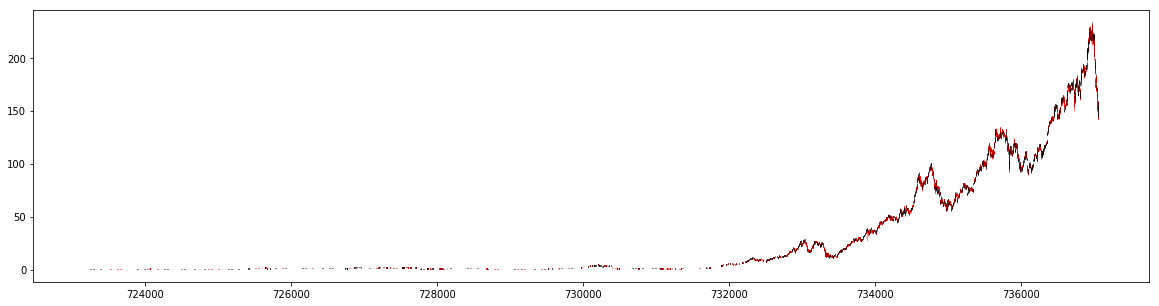

CPU times: user 24.3 s, sys: 360 ms, total: 24.6 s
Wall time: 24.1 s


In [154]:
%%time
plot_ha_candlestick(apple)
plt.show()

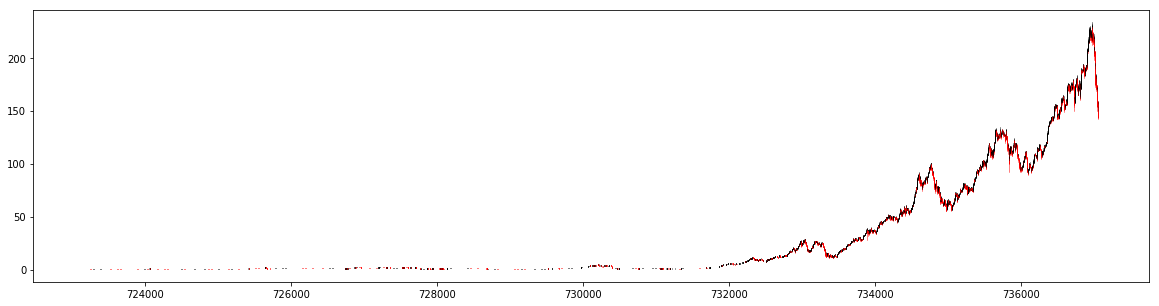

CPU times: user 25.5 s, sys: 396 ms, total: 25.9 s
Wall time: 25.4 s


In [155]:
%%time
plot_ha_candlestick(heikin_ashi(apple))
plt.show()

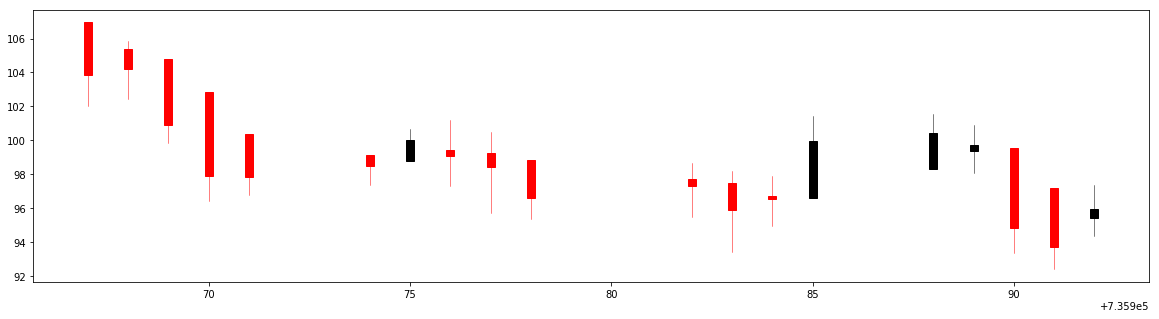

CPU times: user 420 ms, sys: 348 ms, total: 768 ms
Wall time: 327 ms


In [168]:
%%time
apple_ha = heikin_ashi(apple)
apple_ha_2016_01 = apple_ha[(apple_ha.index > '2016-01-01') & (apple_ha.index < '2016-02-01')]
plot_ha_candlestick(apple_ha_2016_01)
plt.show()

## Define trading strategy

In [145]:
def trades(df):
    current = df[1:]
    previous = df.shift(1)[1:]
    
    latest_bearish = current['ha_close'] < current['ha_open']
    previous_bearish = previous['ha_close'] < previous['ha_open']
    
    current_candle_longer = (
        np.abs(current['ha_close'] - current['ha_open']) 
        > np.abs(previous['ha_close'] - previous['ha_open']))
        
    current_open_eq_high = current['ha_open'] == current['ha_high']
    current_open_eq_low = current['ha_open'] == current['ha_low']
        
    long = (
        latest_bearish 
        & current_candle_longer 
        & previous_bearish 
        & current_open_eq_high)
    short = (
        ~latest_bearish 
        & current_candle_longer 
        & ~previous_bearish 
        & current_open_eq_low)

    long_exit = (
        ~latest_bearish 
        & ~previous_bearish 
        & current_open_eq_low)
    short_exit = (
        latest_bearish 
        & previous_bearish 
        & current_open_eq_high)
        
    return pd.DataFrame(
        {'long': long,
         'short': short,
         'long_exit': long_exit,
         'short_exit': short_exit},
        index=current.index)

In [172]:
# Simple test
test_ha = expected_heikin_ashi

expected_trades = pd.DataFrame(
    {'long': [False, True, False, False],
     'short': [False, False, False, False],
     'long_exit': [False, False, False, False],
     'short_exit': [False, True, True, False]},
    index=test_ha.index[1:])

actual_trades = trades(test_ha)

pd.util.testing.assert_almost_equal(
    actual_trades,
    expected_trades)

## Executing positions

In [185]:
def execute(trades, original_index, initial_position=0):
    positions = [initial_position]
    
    for _, trade in trades.iterrows():
        position = positions[-1]
        bought, sold = position > 0, position < 0
        
        close_buy = bought and trade['long_exit']
        close_sell = sold and trade['short_exit']
        
        positions.append(
            1 if trade['long'] else (
            -1 if trade['short'] else (
            0 if (close_buy or close_sell) else (
            position))))
        
    return pd.Series(
        positions, 
        index=original_index, 
        name='positions')

In [188]:
# Simple test
test_trades = expected_trades

expected_positions = pd.Series(
    [0,0,1,1,1], 
    index=test_ha.index, 
    name='positions')

actual_positions = execute(test_trades, test_ha.index)

pd.util.testing.assert_almost_equal(
    actual_positions,
    expected_positions)

## Backtesting

## Fine-tune curve fitting